In [ ]:
# 1차적으로 git clone을 진행한다.
# ultralytics yolov5를 활용.
!git clone https://github.com/ultralytics/yolov5
%pip install -qr requriements.txt

In [1]:
# 필요한 module upload
import torch
# yaml 파일을 만들기 위한 module
import yaml
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
# json file
import json
import os
# XML 어노테이션 파일
import xml.etree.ElementTree as ET
# 이미지를 한 번에 긁어모으기 위한 glob 모듈
from glob import glob
# 파일 이동
import shutil
# Image를 open
from PIL import Image
# plt.imshow()후 커널 dead 현상 제거
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# cuda 연산
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
%cd "C:\\Users\\user\\Desktop\\recognition_project\\yolov5"

C:\Users\user\Desktop\recognition_project\yolov5


In [4]:
pwd

'C:\\Users\\user\\Desktop\\recognition_project\\yolov5'

In [5]:
# 우선 file을 train과 valid, test로 나눠준다
# directory 생성 후 나중에 상황에 맞게 분리 해준다
# path = "./archive"
# img_path = path+"\\"+"images"
# annot_path = path+"\\"+"annotations"
# os.mkdir(img_path+"\\"+"train")
# os.mkdir(img_path+"\\"+"valid")
# os.mkdir(img_path+"\\"+"test")
# os.mkdir(annot_path+"\\"+"train")
# os.mkdir(annot_path+"\\"+"valid")
# os.mkdir(annot_path+"\\"+"test")

In [5]:
# yolov5 model load
# 우선은 따로 구축하진 않고 있는 parameter 활용
# parameter 활용 시 customizing 하는 방법 생각
model = torch.hub.load("ultralytics/yolov5", "yolov5s")

Using cache found in C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-3-30 Python-3.9.13 torch-1.13.1+cu116 CUDA:0 (GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


우선 kaggle의 데이터셋에는 annotation file까지 준비가 된 상태이다.
1. 데이터 파일을 coco 형식으로 만들어 주거나 또는 이미 xml로 annotation 되어 있다.
    - 우선 이미지와 객체에 대한 label 정보를 포함하는 JSON 파일을 생성한다
    - 즉, 이미지와 객체에 대한 label 정보를 포함하는 JSON 파일을 이용하여 이미지와 라벨을 저장한다.
2. 'data.yaml' 파일 생성
    - 클래스 개수와 클래스 이름 설정
        - coco 형식으로 구성된 데이터셋에 대한 클래스 개수와 클래스 이름을 설정한다. 이 정보는 data.yaml에 포함된다
    - 학습/검증 데이터 경로 설정
        - 학습과 검증 데이터 경로를 설정. 이 경로 정보는 data.yaml 파일에 포함
    - data.yaml 파일 생성
        - 설정된 정보를 이용해 data.yaml 파일을 생성. 생성된 파일은 coco 데이터셋을 이용하는 YOLOv5 모델에서 학습에 사용된다.


In [7]:
# xml 파일의 구성이 어떻게 돼 있는지 확인
xml_file = "./archive/annotations/train/hard_hat_workers1.xml"
# xml 파일 열기(parsing)
tree = ET.parse(xml_file)
# xml 파일의 root 요소 가져오기
root = tree.getroot()
# root 요소의 tag 이름 출력
print(root.tag)
# 루트 요소의 자식 요소 출력
for child in root:
    print(child.tag, child.attrib)

annotation
folder {}
filename {}
size {}
segmented {}
object {}
object {}
object {}
object {}
object {}
object {}
object {}
object {}
object {}


다음의 아래의 코드는 annotation된 것을 YOLO에 맞게 변환 시켜준 것이다.
- COCO 형식이 아닌 PASCAL VOC형태.
- XML 형태의 ANNOTATION 파일을 YOLO 형식에 맞게

In [8]:
# YOLO 형식으로 변환할 class 이름을 지정
classes = ["helmet", "head", "person"]
# xml 파일과 이미지 파일이 저장된 폴더 경로를 지정
# 각 train, test, valid 별로 진행해 준다.
types = ["train", "valid", "test"]
# yolo 형식으로 변환된 파일을 저장할 폴더를 생성
%cd "C:\\Users\\user\\Desktop\\recognition_project\\yolov5\\archive"
if not os.path.exists("labels"):
    os.makedirs("labels")
    %cd "C:\\Users\\user\\Desktop\\recognition_project\\yolov5\\archive\\labels"
    os.makedirs("train")
    os.makedirs("valid")
    os.makedirs("test")
    %cd "C:\\Users\\user\\Desktop\\recognition_project\\yolov5\\archive"
# xml 파일을 parsing해서 yolo 형식으로 변환
# os.listdir -> xml 데이터들이 담겨 있다.
cnt = 0
for t in types:
    xml_path = "./annotations/" + t
    image_path = "./images/" + t
    for xml_file_name in os.listdir(xml_path):
        # ./annotations/train\\*.xml
        xml_file_path = os.path.join(xml_path, xml_file_name)
        # xml 파일을 parsing
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        # 이미지 파일 경로 가져오기
        # image_file_name에는 해당 xml에 대응되는 이미지 파일의 이름을 나타낸다.
        image_file_name = root.find("filename").text
        image_file_path = os.path.join(image_path, image_file_name)
        # 이미지 파일 열기
        img = Image.open(image_file_path)
        img_width, img_height = img.size # 폭 x 높이
        # YOLO 형식으로 변환 단계
        # xml_file_name[:-4] 에는 .xml 전까지의 파일 명까지만 cut
        # .txt형태로 변환
        # 각 directory별로 들어가게 된다.
        yolo_file_path = os.path.join("./labels",t,xml_file_name[:-4] + ".txt")
        with open(yolo_file_path, "w") as f:
            # 해당 xml 파일에서 <object> element를 찾아서 반복적으로 처리하는 코드.
            # <object> element는 객체의 정보를 포함하고 있다.
            # 각 객체의 정보를 추출한다. 추출된 정보를 사용하여 YOLO 형식으로 변환한 뒤, 텍스트 파일에 저장
            # 반복문을 통해 object를 하나씩 가져온다.
            for obj in root.findall("object"):
                # 각 객체 클래스의 클래스 이름을 문자열로 저장
                # class명을 하나씩 가져온다
                class_name = obj.find("name").text
                # 해당 cell의 맨 위에 classes를 정의하였다.
                # classes.index(class_name) 이라고 하면 내가 정의한 list의 순서대로 index를 반환한다.
                class_id = classes.index(class_name)

                # 해당 <object> element에서 하위 element인 bndbox element를 찾아서 반환한다.
                bbox = obj.find("bndbox")
                x_min = int(bbox.find("xmin").text)
                y_min = int(bbox.find("ymin").text)
                x_max = int(bbox.find("xmax").text)
                y_max = int(bbox.find("ymax").text)

                # normalize 시켜주는 과정
                # 1.0은 이미지의 너비 또는 높이를 1로 정규화 하는데 사용
                dx = 1/int(img.size[0])
                dy = 1/int(img.size[1])
                # x_center는 해당 객체의 bounding box 중심점의 x좌표
                # 값을 YOLO 형식으로 bounding box 좌표를 변환하기 위해 사용
                # 0 ~ 1 사이로 정규화 되어 있으므로 이 값을 YOLO 형식으로 변환 시에도 0 ~ 1
                # y_center도 마찬가지의 원리
                # x_center, y_center, w, h는 YOLO 형식으로 bounding box 좌표를 나타내는 값
                # YOLO: 이미지를 Grid로 나누고 각 grid 셀마다 bounding box를 예측
                # bounding box는 해당 셀에 대해 상대적인 위치와 크기로 표현
                # 이를 위해 x_center, y_center, w, h를 사용한다
                # x_center: bounding box 중심점의 x 좌표
                x_center = (x_min+x_max) / 2 * dx
                # y_center: bounding box의 중심점의 y좌표
                y_center = (y_min+y_max) / 2 * dy
                # bounding box의 너비(해당 셀의 너비를 기준으로 상대적인 크기)
                w = (x_max - x_min) / img_width
                # bounding box의 높이(해당 셀의 높이를 기준으로 한 상대적인 크기)
                h = (y_max - y_min) / img_height

                # YOLO 형식으로 변환된 Bounding box 정보를 txt 파일에 기록
                # class_id: 해당 객체의 class id를 나타낸다.
                # classes에 설정된 class 명의 index를 할당
                # helmet, head, person의 클래스 ID를 할당
                # x_center, y_center, w, h는 YOLO 형식으로 bounding box 좌표를 나타낸다.
                f.write(f"{class_id} {x_center:.5f} {y_center:.5f} {w:.5f} {h:.5f}\n")
            print("Convert these files, {} file and {} file, into the YOLO format".format(xml_file_name, image_file_name))

C:\Users\user\Desktop\recognition_project\yolov5\archive
C:\Users\user\Desktop\recognition_project\yolov5\archive\labels
C:\Users\user\Desktop\recognition_project\yolov5\archive
Convert these files, hard_hat_workers0.xml file and hard_hat_workers0.png file, into the YOLO format
Convert these files, hard_hat_workers1.xml file and hard_hat_workers1.png file, into the YOLO format
Convert these files, hard_hat_workers10.xml file and hard_hat_workers10.png file, into the YOLO format
Convert these files, hard_hat_workers100.xml file and hard_hat_workers100.png file, into the YOLO format
Convert these files, hard_hat_workers1000.xml file and hard_hat_workers1000.png file, into the YOLO format
Convert these files, hard_hat_workers1001.xml file and hard_hat_workers1001.png file, into the YOLO format
Convert these files, hard_hat_workers1002.xml file and hard_hat_workers1002.png file, into the YOLO format
Convert these files, hard_hat_workers1003.xml file and hard_hat_workers1003.png file, into 

Convert these files, hard_hat_workers1247.xml file and hard_hat_workers1247.png file, into the YOLO format
Convert these files, hard_hat_workers1248.xml file and hard_hat_workers1248.png file, into the YOLO format
Convert these files, hard_hat_workers1249.xml file and hard_hat_workers1249.png file, into the YOLO format
Convert these files, hard_hat_workers125.xml file and hard_hat_workers125.png file, into the YOLO format
Convert these files, hard_hat_workers1250.xml file and hard_hat_workers1250.png file, into the YOLO format
Convert these files, hard_hat_workers1251.xml file and hard_hat_workers1251.png file, into the YOLO format
Convert these files, hard_hat_workers1252.xml file and hard_hat_workers1252.png file, into the YOLO format
Convert these files, hard_hat_workers1253.xml file and hard_hat_workers1253.png file, into the YOLO format
Convert these files, hard_hat_workers1254.xml file and hard_hat_workers1254.png file, into the YOLO format
Convert these files, hard_hat_workers12

Convert these files, hard_hat_workers133.xml file and hard_hat_workers133.png file, into the YOLO format
Convert these files, hard_hat_workers1330.xml file and hard_hat_workers1330.png file, into the YOLO format
Convert these files, hard_hat_workers1331.xml file and hard_hat_workers1331.png file, into the YOLO format
Convert these files, hard_hat_workers1332.xml file and hard_hat_workers1332.png file, into the YOLO format
Convert these files, hard_hat_workers1333.xml file and hard_hat_workers1333.png file, into the YOLO format
Convert these files, hard_hat_workers1334.xml file and hard_hat_workers1334.png file, into the YOLO format
Convert these files, hard_hat_workers1335.xml file and hard_hat_workers1335.png file, into the YOLO format
Convert these files, hard_hat_workers1336.xml file and hard_hat_workers1336.png file, into the YOLO format
Convert these files, hard_hat_workers1337.xml file and hard_hat_workers1337.png file, into the YOLO format
Convert these files, hard_hat_workers13

Convert these files, hard_hat_workers1650.xml file and hard_hat_workers1650.png file, into the YOLO format
Convert these files, hard_hat_workers1651.xml file and hard_hat_workers1651.png file, into the YOLO format
Convert these files, hard_hat_workers1652.xml file and hard_hat_workers1652.png file, into the YOLO format
Convert these files, hard_hat_workers1653.xml file and hard_hat_workers1653.png file, into the YOLO format
Convert these files, hard_hat_workers1654.xml file and hard_hat_workers1654.png file, into the YOLO format
Convert these files, hard_hat_workers1655.xml file and hard_hat_workers1655.png file, into the YOLO format
Convert these files, hard_hat_workers1656.xml file and hard_hat_workers1656.png file, into the YOLO format
Convert these files, hard_hat_workers1657.xml file and hard_hat_workers1657.png file, into the YOLO format
Convert these files, hard_hat_workers1658.xml file and hard_hat_workers1658.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers1723.xml file and hard_hat_workers1723.png file, into the YOLO format
Convert these files, hard_hat_workers1724.xml file and hard_hat_workers1724.png file, into the YOLO format
Convert these files, hard_hat_workers1725.xml file and hard_hat_workers1725.png file, into the YOLO format
Convert these files, hard_hat_workers1726.xml file and hard_hat_workers1726.png file, into the YOLO format
Convert these files, hard_hat_workers1727.xml file and hard_hat_workers1727.png file, into the YOLO format
Convert these files, hard_hat_workers1728.xml file and hard_hat_workers1728.png file, into the YOLO format
Convert these files, hard_hat_workers1729.xml file and hard_hat_workers1729.png file, into the YOLO format
Convert these files, hard_hat_workers173.xml file and hard_hat_workers173.png file, into the YOLO format
Convert these files, hard_hat_workers1730.xml file and hard_hat_workers1730.png file, into the YOLO format
Convert these files, hard_hat_workers17

Convert these files, hard_hat_workers20.xml file and hard_hat_workers20.png file, into the YOLO format
Convert these files, hard_hat_workers200.xml file and hard_hat_workers200.png file, into the YOLO format
Convert these files, hard_hat_workers2000.xml file and hard_hat_workers2000.png file, into the YOLO format
Convert these files, hard_hat_workers2001.xml file and hard_hat_workers2001.png file, into the YOLO format
Convert these files, hard_hat_workers2002.xml file and hard_hat_workers2002.png file, into the YOLO format
Convert these files, hard_hat_workers2003.xml file and hard_hat_workers2003.png file, into the YOLO format
Convert these files, hard_hat_workers2004.xml file and hard_hat_workers2004.png file, into the YOLO format
Convert these files, hard_hat_workers2005.xml file and hard_hat_workers2005.png file, into the YOLO format
Convert these files, hard_hat_workers2006.xml file and hard_hat_workers2006.png file, into the YOLO format
Convert these files, hard_hat_workers2007.x

Convert these files, hard_hat_workers2109.xml file and hard_hat_workers2109.png file, into the YOLO format
Convert these files, hard_hat_workers211.xml file and hard_hat_workers211.png file, into the YOLO format
Convert these files, hard_hat_workers2110.xml file and hard_hat_workers2110.png file, into the YOLO format
Convert these files, hard_hat_workers2111.xml file and hard_hat_workers2111.png file, into the YOLO format
Convert these files, hard_hat_workers2112.xml file and hard_hat_workers2112.png file, into the YOLO format
Convert these files, hard_hat_workers2113.xml file and hard_hat_workers2113.png file, into the YOLO format
Convert these files, hard_hat_workers2114.xml file and hard_hat_workers2114.png file, into the YOLO format
Convert these files, hard_hat_workers2115.xml file and hard_hat_workers2115.png file, into the YOLO format
Convert these files, hard_hat_workers2116.xml file and hard_hat_workers2116.png file, into the YOLO format
Convert these files, hard_hat_workers21

Convert these files, hard_hat_workers2365.xml file and hard_hat_workers2365.png file, into the YOLO format
Convert these files, hard_hat_workers2366.xml file and hard_hat_workers2366.png file, into the YOLO format
Convert these files, hard_hat_workers2367.xml file and hard_hat_workers2367.png file, into the YOLO format
Convert these files, hard_hat_workers2368.xml file and hard_hat_workers2368.png file, into the YOLO format
Convert these files, hard_hat_workers2369.xml file and hard_hat_workers2369.png file, into the YOLO format
Convert these files, hard_hat_workers237.xml file and hard_hat_workers237.png file, into the YOLO format
Convert these files, hard_hat_workers2370.xml file and hard_hat_workers2370.png file, into the YOLO format
Convert these files, hard_hat_workers2371.xml file and hard_hat_workers2371.png file, into the YOLO format
Convert these files, hard_hat_workers2372.xml file and hard_hat_workers2372.png file, into the YOLO format
Convert these files, hard_hat_workers23

Convert these files, hard_hat_workers2476.xml file and hard_hat_workers2476.png file, into the YOLO format
Convert these files, hard_hat_workers2477.xml file and hard_hat_workers2477.png file, into the YOLO format
Convert these files, hard_hat_workers2478.xml file and hard_hat_workers2478.png file, into the YOLO format
Convert these files, hard_hat_workers2479.xml file and hard_hat_workers2479.png file, into the YOLO format
Convert these files, hard_hat_workers248.xml file and hard_hat_workers248.png file, into the YOLO format
Convert these files, hard_hat_workers2480.xml file and hard_hat_workers2480.png file, into the YOLO format
Convert these files, hard_hat_workers2481.xml file and hard_hat_workers2481.png file, into the YOLO format
Convert these files, hard_hat_workers2482.xml file and hard_hat_workers2482.png file, into the YOLO format
Convert these files, hard_hat_workers2483.xml file and hard_hat_workers2483.png file, into the YOLO format
Convert these files, hard_hat_workers24

Convert these files, hard_hat_workers2755.xml file and hard_hat_workers2755.png file, into the YOLO format
Convert these files, hard_hat_workers2756.xml file and hard_hat_workers2756.png file, into the YOLO format
Convert these files, hard_hat_workers2757.xml file and hard_hat_workers2757.png file, into the YOLO format
Convert these files, hard_hat_workers2758.xml file and hard_hat_workers2758.png file, into the YOLO format
Convert these files, hard_hat_workers2759.xml file and hard_hat_workers2759.png file, into the YOLO format
Convert these files, hard_hat_workers276.xml file and hard_hat_workers276.png file, into the YOLO format
Convert these files, hard_hat_workers2760.xml file and hard_hat_workers2760.png file, into the YOLO format
Convert these files, hard_hat_workers2761.xml file and hard_hat_workers2761.png file, into the YOLO format
Convert these files, hard_hat_workers2762.xml file and hard_hat_workers2762.png file, into the YOLO format
Convert these files, hard_hat_workers27

Convert these files, hard_hat_workers2839.xml file and hard_hat_workers2839.png file, into the YOLO format
Convert these files, hard_hat_workers284.xml file and hard_hat_workers284.png file, into the YOLO format
Convert these files, hard_hat_workers2840.xml file and hard_hat_workers2840.png file, into the YOLO format
Convert these files, hard_hat_workers2841.xml file and hard_hat_workers2841.png file, into the YOLO format
Convert these files, hard_hat_workers2842.xml file and hard_hat_workers2842.png file, into the YOLO format
Convert these files, hard_hat_workers2843.xml file and hard_hat_workers2843.png file, into the YOLO format
Convert these files, hard_hat_workers2844.xml file and hard_hat_workers2844.png file, into the YOLO format
Convert these files, hard_hat_workers2845.xml file and hard_hat_workers2845.png file, into the YOLO format
Convert these files, hard_hat_workers2846.xml file and hard_hat_workers2846.png file, into the YOLO format
Convert these files, hard_hat_workers28

Convert these files, hard_hat_workers397.xml file and hard_hat_workers397.png file, into the YOLO format
Convert these files, hard_hat_workers398.xml file and hard_hat_workers398.png file, into the YOLO format
Convert these files, hard_hat_workers399.xml file and hard_hat_workers399.png file, into the YOLO format
Convert these files, hard_hat_workers4.xml file and hard_hat_workers4.png file, into the YOLO format
Convert these files, hard_hat_workers40.xml file and hard_hat_workers40.png file, into the YOLO format
Convert these files, hard_hat_workers400.xml file and hard_hat_workers400.png file, into the YOLO format
Convert these files, hard_hat_workers401.xml file and hard_hat_workers401.png file, into the YOLO format
Convert these files, hard_hat_workers402.xml file and hard_hat_workers402.png file, into the YOLO format
Convert these files, hard_hat_workers403.xml file and hard_hat_workers403.png file, into the YOLO format
Convert these files, hard_hat_workers404.xml file and hard_ha

Convert these files, hard_hat_workers782.xml file and hard_hat_workers782.png file, into the YOLO format
Convert these files, hard_hat_workers783.xml file and hard_hat_workers783.png file, into the YOLO format
Convert these files, hard_hat_workers784.xml file and hard_hat_workers784.png file, into the YOLO format
Convert these files, hard_hat_workers785.xml file and hard_hat_workers785.png file, into the YOLO format
Convert these files, hard_hat_workers786.xml file and hard_hat_workers786.png file, into the YOLO format
Convert these files, hard_hat_workers787.xml file and hard_hat_workers787.png file, into the YOLO format
Convert these files, hard_hat_workers788.xml file and hard_hat_workers788.png file, into the YOLO format
Convert these files, hard_hat_workers789.xml file and hard_hat_workers789.png file, into the YOLO format
Convert these files, hard_hat_workers79.xml file and hard_hat_workers79.png file, into the YOLO format
Convert these files, hard_hat_workers790.xml file and har

Convert these files, hard_hat_workers3148.xml file and hard_hat_workers3148.png file, into the YOLO format
Convert these files, hard_hat_workers3149.xml file and hard_hat_workers3149.png file, into the YOLO format
Convert these files, hard_hat_workers3150.xml file and hard_hat_workers3150.png file, into the YOLO format
Convert these files, hard_hat_workers3151.xml file and hard_hat_workers3151.png file, into the YOLO format
Convert these files, hard_hat_workers3152.xml file and hard_hat_workers3152.png file, into the YOLO format
Convert these files, hard_hat_workers3153.xml file and hard_hat_workers3153.png file, into the YOLO format
Convert these files, hard_hat_workers3154.xml file and hard_hat_workers3154.png file, into the YOLO format
Convert these files, hard_hat_workers3155.xml file and hard_hat_workers3155.png file, into the YOLO format
Convert these files, hard_hat_workers3156.xml file and hard_hat_workers3156.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers3486.xml file and hard_hat_workers3486.png file, into the YOLO format
Convert these files, hard_hat_workers3487.xml file and hard_hat_workers3487.png file, into the YOLO format
Convert these files, hard_hat_workers3488.xml file and hard_hat_workers3488.png file, into the YOLO format
Convert these files, hard_hat_workers3489.xml file and hard_hat_workers3489.png file, into the YOLO format
Convert these files, hard_hat_workers3490.xml file and hard_hat_workers3490.png file, into the YOLO format
Convert these files, hard_hat_workers3491.xml file and hard_hat_workers3491.png file, into the YOLO format
Convert these files, hard_hat_workers3492.xml file and hard_hat_workers3492.png file, into the YOLO format
Convert these files, hard_hat_workers3493.xml file and hard_hat_workers3493.png file, into the YOLO format
Convert these files, hard_hat_workers3494.xml file and hard_hat_workers3494.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers3816.xml file and hard_hat_workers3816.png file, into the YOLO format
Convert these files, hard_hat_workers3817.xml file and hard_hat_workers3817.png file, into the YOLO format
Convert these files, hard_hat_workers3818.xml file and hard_hat_workers3818.png file, into the YOLO format
Convert these files, hard_hat_workers3819.xml file and hard_hat_workers3819.png file, into the YOLO format
Convert these files, hard_hat_workers3820.xml file and hard_hat_workers3820.png file, into the YOLO format
Convert these files, hard_hat_workers3821.xml file and hard_hat_workers3821.png file, into the YOLO format
Convert these files, hard_hat_workers3822.xml file and hard_hat_workers3822.png file, into the YOLO format
Convert these files, hard_hat_workers3823.xml file and hard_hat_workers3823.png file, into the YOLO format
Convert these files, hard_hat_workers3824.xml file and hard_hat_workers3824.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4018.xml file and hard_hat_workers4018.png file, into the YOLO format
Convert these files, hard_hat_workers4019.xml file and hard_hat_workers4019.png file, into the YOLO format
Convert these files, hard_hat_workers4020.xml file and hard_hat_workers4020.png file, into the YOLO format
Convert these files, hard_hat_workers4021.xml file and hard_hat_workers4021.png file, into the YOLO format
Convert these files, hard_hat_workers4022.xml file and hard_hat_workers4022.png file, into the YOLO format
Convert these files, hard_hat_workers4023.xml file and hard_hat_workers4023.png file, into the YOLO format
Convert these files, hard_hat_workers4024.xml file and hard_hat_workers4024.png file, into the YOLO format
Convert these files, hard_hat_workers4025.xml file and hard_hat_workers4025.png file, into the YOLO format
Convert these files, hard_hat_workers4026.xml file and hard_hat_workers4026.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4121.xml file and hard_hat_workers4121.png file, into the YOLO format
Convert these files, hard_hat_workers4122.xml file and hard_hat_workers4122.png file, into the YOLO format
Convert these files, hard_hat_workers4123.xml file and hard_hat_workers4123.png file, into the YOLO format
Convert these files, hard_hat_workers4124.xml file and hard_hat_workers4124.png file, into the YOLO format
Convert these files, hard_hat_workers4125.xml file and hard_hat_workers4125.png file, into the YOLO format
Convert these files, hard_hat_workers4126.xml file and hard_hat_workers4126.png file, into the YOLO format
Convert these files, hard_hat_workers4127.xml file and hard_hat_workers4127.png file, into the YOLO format
Convert these files, hard_hat_workers4128.xml file and hard_hat_workers4128.png file, into the YOLO format
Convert these files, hard_hat_workers4129.xml file and hard_hat_workers4129.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4211.xml file and hard_hat_workers4211.png file, into the YOLO format
Convert these files, hard_hat_workers4212.xml file and hard_hat_workers4212.png file, into the YOLO format
Convert these files, hard_hat_workers4213.xml file and hard_hat_workers4213.png file, into the YOLO format
Convert these files, hard_hat_workers4214.xml file and hard_hat_workers4214.png file, into the YOLO format
Convert these files, hard_hat_workers4215.xml file and hard_hat_workers4215.png file, into the YOLO format
Convert these files, hard_hat_workers4216.xml file and hard_hat_workers4216.png file, into the YOLO format
Convert these files, hard_hat_workers4217.xml file and hard_hat_workers4217.png file, into the YOLO format
Convert these files, hard_hat_workers4218.xml file and hard_hat_workers4218.png file, into the YOLO format
Convert these files, hard_hat_workers4219.xml file and hard_hat_workers4219.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4296.xml file and hard_hat_workers4296.png file, into the YOLO format
Convert these files, hard_hat_workers4297.xml file and hard_hat_workers4297.png file, into the YOLO format
Convert these files, hard_hat_workers4298.xml file and hard_hat_workers4298.png file, into the YOLO format
Convert these files, hard_hat_workers4299.xml file and hard_hat_workers4299.png file, into the YOLO format
Convert these files, hard_hat_workers4300.xml file and hard_hat_workers4300.png file, into the YOLO format
Convert these files, hard_hat_workers4301.xml file and hard_hat_workers4301.png file, into the YOLO format
Convert these files, hard_hat_workers4302.xml file and hard_hat_workers4302.png file, into the YOLO format
Convert these files, hard_hat_workers4303.xml file and hard_hat_workers4303.png file, into the YOLO format
Convert these files, hard_hat_workers4304.xml file and hard_hat_workers4304.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4378.xml file and hard_hat_workers4378.png file, into the YOLO format
Convert these files, hard_hat_workers4379.xml file and hard_hat_workers4379.png file, into the YOLO format
Convert these files, hard_hat_workers4380.xml file and hard_hat_workers4380.png file, into the YOLO format
Convert these files, hard_hat_workers4381.xml file and hard_hat_workers4381.png file, into the YOLO format
Convert these files, hard_hat_workers4382.xml file and hard_hat_workers4382.png file, into the YOLO format
Convert these files, hard_hat_workers4383.xml file and hard_hat_workers4383.png file, into the YOLO format
Convert these files, hard_hat_workers4384.xml file and hard_hat_workers4384.png file, into the YOLO format
Convert these files, hard_hat_workers4385.xml file and hard_hat_workers4385.png file, into the YOLO format
Convert these files, hard_hat_workers4386.xml file and hard_hat_workers4386.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4462.xml file and hard_hat_workers4462.png file, into the YOLO format
Convert these files, hard_hat_workers4463.xml file and hard_hat_workers4463.png file, into the YOLO format
Convert these files, hard_hat_workers4464.xml file and hard_hat_workers4464.png file, into the YOLO format
Convert these files, hard_hat_workers4465.xml file and hard_hat_workers4465.png file, into the YOLO format
Convert these files, hard_hat_workers4466.xml file and hard_hat_workers4466.png file, into the YOLO format
Convert these files, hard_hat_workers4467.xml file and hard_hat_workers4467.png file, into the YOLO format
Convert these files, hard_hat_workers4468.xml file and hard_hat_workers4468.png file, into the YOLO format
Convert these files, hard_hat_workers4469.xml file and hard_hat_workers4469.png file, into the YOLO format
Convert these files, hard_hat_workers4470.xml file and hard_hat_workers4470.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4549.xml file and hard_hat_workers4549.png file, into the YOLO format
Convert these files, hard_hat_workers4550.xml file and hard_hat_workers4550.png file, into the YOLO format
Convert these files, hard_hat_workers4551.xml file and hard_hat_workers4551.png file, into the YOLO format
Convert these files, hard_hat_workers4552.xml file and hard_hat_workers4552.png file, into the YOLO format
Convert these files, hard_hat_workers4553.xml file and hard_hat_workers4553.png file, into the YOLO format
Convert these files, hard_hat_workers4554.xml file and hard_hat_workers4554.png file, into the YOLO format
Convert these files, hard_hat_workers4555.xml file and hard_hat_workers4555.png file, into the YOLO format
Convert these files, hard_hat_workers4556.xml file and hard_hat_workers4556.png file, into the YOLO format
Convert these files, hard_hat_workers4557.xml file and hard_hat_workers4557.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4634.xml file and hard_hat_workers4634.png file, into the YOLO format
Convert these files, hard_hat_workers4635.xml file and hard_hat_workers4635.png file, into the YOLO format
Convert these files, hard_hat_workers4636.xml file and hard_hat_workers4636.png file, into the YOLO format
Convert these files, hard_hat_workers4637.xml file and hard_hat_workers4637.png file, into the YOLO format
Convert these files, hard_hat_workers4638.xml file and hard_hat_workers4638.png file, into the YOLO format
Convert these files, hard_hat_workers4639.xml file and hard_hat_workers4639.png file, into the YOLO format
Convert these files, hard_hat_workers4640.xml file and hard_hat_workers4640.png file, into the YOLO format
Convert these files, hard_hat_workers4641.xml file and hard_hat_workers4641.png file, into the YOLO format
Convert these files, hard_hat_workers4642.xml file and hard_hat_workers4642.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4724.xml file and hard_hat_workers4724.png file, into the YOLO format
Convert these files, hard_hat_workers4725.xml file and hard_hat_workers4725.png file, into the YOLO format
Convert these files, hard_hat_workers4726.xml file and hard_hat_workers4726.png file, into the YOLO format
Convert these files, hard_hat_workers4727.xml file and hard_hat_workers4727.png file, into the YOLO format
Convert these files, hard_hat_workers4728.xml file and hard_hat_workers4728.png file, into the YOLO format
Convert these files, hard_hat_workers4729.xml file and hard_hat_workers4729.png file, into the YOLO format
Convert these files, hard_hat_workers4730.xml file and hard_hat_workers4730.png file, into the YOLO format
Convert these files, hard_hat_workers4731.xml file and hard_hat_workers4731.png file, into the YOLO format
Convert these files, hard_hat_workers4732.xml file and hard_hat_workers4732.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4810.xml file and hard_hat_workers4810.png file, into the YOLO format
Convert these files, hard_hat_workers4811.xml file and hard_hat_workers4811.png file, into the YOLO format
Convert these files, hard_hat_workers4812.xml file and hard_hat_workers4812.png file, into the YOLO format
Convert these files, hard_hat_workers4813.xml file and hard_hat_workers4813.png file, into the YOLO format
Convert these files, hard_hat_workers4814.xml file and hard_hat_workers4814.png file, into the YOLO format
Convert these files, hard_hat_workers4815.xml file and hard_hat_workers4815.png file, into the YOLO format
Convert these files, hard_hat_workers4816.xml file and hard_hat_workers4816.png file, into the YOLO format
Convert these files, hard_hat_workers4817.xml file and hard_hat_workers4817.png file, into the YOLO format
Convert these files, hard_hat_workers4818.xml file and hard_hat_workers4818.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4896.xml file and hard_hat_workers4896.png file, into the YOLO format
Convert these files, hard_hat_workers4897.xml file and hard_hat_workers4897.png file, into the YOLO format
Convert these files, hard_hat_workers4898.xml file and hard_hat_workers4898.png file, into the YOLO format
Convert these files, hard_hat_workers4899.xml file and hard_hat_workers4899.png file, into the YOLO format
Convert these files, hard_hat_workers4900.xml file and hard_hat_workers4900.png file, into the YOLO format
Convert these files, hard_hat_workers4901.xml file and hard_hat_workers4901.png file, into the YOLO format
Convert these files, hard_hat_workers4902.xml file and hard_hat_workers4902.png file, into the YOLO format
Convert these files, hard_hat_workers4903.xml file and hard_hat_workers4903.png file, into the YOLO format
Convert these files, hard_hat_workers4904.xml file and hard_hat_workers4904.png file, into the YOLO format
Convert these files, hard_hat_workers

Convert these files, hard_hat_workers4988.xml file and hard_hat_workers4988.png file, into the YOLO format
Convert these files, hard_hat_workers4989.xml file and hard_hat_workers4989.png file, into the YOLO format
Convert these files, hard_hat_workers4990.xml file and hard_hat_workers4990.png file, into the YOLO format
Convert these files, hard_hat_workers4991.xml file and hard_hat_workers4991.png file, into the YOLO format
Convert these files, hard_hat_workers4992.xml file and hard_hat_workers4992.png file, into the YOLO format
Convert these files, hard_hat_workers4993.xml file and hard_hat_workers4993.png file, into the YOLO format
Convert these files, hard_hat_workers4994.xml file and hard_hat_workers4994.png file, into the YOLO format
Convert these files, hard_hat_workers4995.xml file and hard_hat_workers4995.png file, into the YOLO format
Convert these files, hard_hat_workers4996.xml file and hard_hat_workers4996.png file, into the YOLO format
Convert these files, hard_hat_workers

In [9]:
# yaml 파일 제작
# train, test, valid, number of classes, classes name 지정
%cd "C:\\Users\\user\\Desktop\\recognition_project\\yolov5\\archive"
data = {'train': "./archive/images/train",
        'test': "./archive/images/test",
        "val": "./archive/images/valid",
        "nc": "3",
        "names": ['helmet', 'head', 'person']}

# data.yaml은 위의 dictionary 변수 명과 같이 한다.
with open("data.yaml", "w") as f:
    yaml.dump(data, f)

C:\Users\user\Desktop\recognition_project\yolov5\archive


In [10]:
%cd "C:\\Users\\user\\Desktop\\recognition_project\\yolov5"

C:\Users\user\Desktop\recognition_project\yolov5


In [11]:
pwd

'C:\\Users\\user\\Desktop\\recognition_project\\yolov5'

In [12]:
torch.cuda.init()

In [6]:
# 추후에 프로젝트 시작 후에 train, validation, test 진행
# --conf 옵션은 confidence(신뢰도) 임계값을 설정하는 옵션이다.
# batch 256 이상은 학습 중에 GPU 메모리 부족을 야기할 수 있다.
!python train.py --img 416 --batch 16 --epochs 20 --data ./archive/data.yaml --cfg ./models/yolov5s.yaml --weights ./runs/train/exp/weights/best.pt --device cuda:0

github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5


train: weights=./runs/train/exp/weights/best.pt, cfg=./models/yolov5s.yaml, data=./archive/data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=cuda:0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5  v7.0-133-gcca5e21 Python-3.9.13 torch-1.13.1+cu116 CUDA:0 (GeForce RTX 3060 Laptop GPU, 6144MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, h

In [16]:
!python detect.py --source "./archive/images/test" --weights "./runs/train/exp/weights/best.pt" --device cuda:0

detect: weights=['./runs/train/exp/weights/best.pt'], source=./archive/images/test, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=cuda:0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-133-gcca5e21 Python-3.9.13 torch-1.13.1+cu116 CUDA:0 (GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1000 C:\Users\user\Desktop\recognition_project\yolov5\archive\images\test\hard_hat_workers4000.png: 640x640 4 helmets, 1 person, 14.5ms
image 2/1000 C:\Users\user\Desktop\recognition_project\yolov5\archive\images\test\hard_hat_workers4001.png: 640x640 8 heads, 0.0ms
image 3/1000 C:\Users\user\Desktop\recogni

70 epoch 학습 결과
- 헬멧을 쓴 사람이면 helmet으로 예측
- 헬멧이 아닌 사람이면 head로 예측

In [8]:
!python detect.py --source "./archive/images/test" --weights "./runs/train/exp2/weights/best.pt" --device cuda:0

detect: weights=['./runs/train/exp2/weights/best.pt'], source=./archive/images/test, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=cuda:0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-133-gcca5e21 Python-3.9.13 torch-1.13.1+cu116 CUDA:0 (GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1000 C:\Users\user\Desktop\recognition_project\yolov5\archive\images\test\hard_hat_workers4000.png: 640x640 4 helmets, 15.7ms
image 2/1000 C:\Users\user\Desktop\recognition_project\yolov5\archive\images\test\hard_hat_workers4001.png: 640x640 7 heads, 15.6ms
image 3/1000 C:\Users\user\Desktop\recognition_pro

In [12]:
picts = os.listdir("./runs/detect/exp")

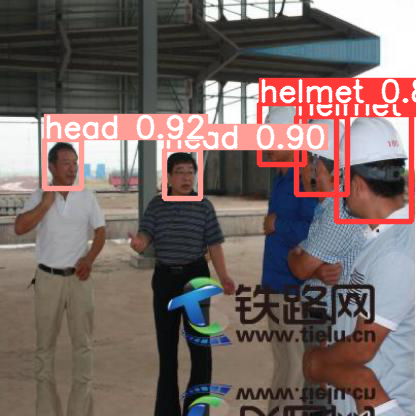

In [17]:
Image.open("./runs/detect/exp"+"\\"+picts[3])